### Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import warnings
import random

%matplotlib inline

### Reading Data

In [5]:
rest_data = pd.read_csv("C:/Users/aryan/OneDrive/Desktop/NYU DSGA3001/zomato.csv")
#rest_data = pd.read_csv("zomato.csv")
#rest_data = pd.read_csv("/Users/mallorysico/Desktop/ProbabilityAndStatistics_1002/Project/zomato.csv")

### Data Cleaning

##### Removing Duplicate Entries

In [6]:
rest_data = rest_data.drop_duplicates('url')

##### Removing menu_item as almost all columns are empty lists

In [7]:
rest_data.drop('menu_item',axis=1,inplace=True)

##### Checking for NaNs in relevant columns

In [8]:
#21 null values in location column 
rest_data['location'].isna().sum()

#227 null in rest_type
rest_data['rest_type'].isna().sum()

#20252 null in dish_liked, 28078 null values in dish_liked column without removing any others
rest_data['dish_liked'].isna().sum()

#11 null in dish_liked, 45 null values in dish_liked column without removing any others
rest_data['cuisines'].isna().sum()

#11 null, 45 null values in column without removing any others
rest_data['cuisines'].isna().sum()

#247 null, 346 null values column without removing any others
rest_data['approx_cost(for two people)'].isna().sum()

#0 null, 0 null values column without removing any others
rest_data['reviews_list'].isna().sum()

#'menu_item' dropped in dataset

#0 null, 0 null values column without removing any others
rest_data['listed_in(type)'].isna().sum()

print('We have checked for nulls in the relevant columns')

We have checked for nulls in the relevant columns


##### Dropping NaNs for columns where imputation would not make business sense/harm the problem statement

In [9]:
rest_data.dropna(subset=['rate','location','rest_type','cuisines','approx_cost(for two people)'],inplace=True)

In [10]:
rest_data = rest_data.reset_index()
rest_data.drop('index',axis=1,inplace=True)

In [11]:
#Data cleaning: 
#Change pricing and any other numerical columns to integers
#Change rate to single number (not x/5)

In [12]:
#Remove commas from the numbers in the approx_cost
rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].str.replace(',', '')

##### Extracting the rating from the 'rate' column (Getting 3.7 from "3.7/5")

In [13]:
rest_data['approx_cost(for two people)'] = rest_data['approx_cost(for two people)'].astype('Int64')

#Keep only the rating and convert to float (remove the '/5' for each entry)
rest_data['rate'] = rest_data['rate'].astype('str')

#Split string by '/'
rest_data['rate'] = rest_data['rate'].str.split('/').str[0]

#Convert to float
rest_data['rate'] = pd.to_numeric(rest_data['rate'], errors = 'coerce')

##### Making a normalized ratings column

In [14]:
ratings_mean = rest_data['rate'].mean()
ratings_std = rest_data['rate'].std()
rest_data['normalized_ratings'] = (rest_data['rate']-ratings_mean)/ratings_std

##### Making a column that counts the cuisines listed on the restaurant

In [15]:
cuisine_count = np.zeros(len(rest_data['cuisines']))

for i in range(len(rest_data['cuisines'])):
    cuisine_count[i] = len(rest_data['cuisines'][i].split(', '))
    
rest_data['cuisines_count'] = cuisine_count

In [16]:
print('The correlation between ratings and the number of cuisines offered is:',rest_data['rate'].corr(rest_data['cuisines_count']))

The correlation between ratings and the number of cuisines offered is: 0.20674347150298625


##### Making columns for cuisines offered at a restaurant (so the data becomes easier to read). The most amount of permitted cuisines on the site is 8, so we have columns from 'cuisine_1' to 'cuisine_8'

In [17]:
cuisine_list = []

for i in range(len(rest_data['cuisines'])):
    cuisine_list.append(rest_data['cuisines'][i].split(', ')) 

rest_data['cuisines_list'] = cuisine_list

In [18]:
rest_data[['cuisine_1', 'cuisine_2', 'cuisine_3','cuisine_4','cuisine_5','cuisine_6','cuisine_7','cuisine_8']] = rest_data['cuisines_list'].apply(
    lambda x: pd.Series([x[0], x[1] if len(x) > 1 else None, x[2] if len(x) > 2 else None, x[3] if len(x) > 3 else None,
                         x[4] if len(x) > 4 else None, x[5] if len(x) > 5 else None, x[6] if len(x) > 6 else None,
                         x[7] if len(x) > 7 else None])
)

##### Making a 'price_range' column that buckets the approx_cost_for_2 ('$','$$','$$$','$$$$')

In [19]:
rest_data['price_range'] = 0
rest_data.loc[rest_data['approx_cost(for two people)'] <= 250, 'price_range'] = '$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 250) & (rest_data['approx_cost(for two people)'] < 500), 'price_range'] = '$$'
rest_data.loc[(rest_data['approx_cost(for two people)'] >= 500) & (rest_data['approx_cost(for two people)'] < 1000), 'price_range'] = '$$$'
rest_data.loc[rest_data['approx_cost(for two people)'] >= 1000, 'price_range'] = '$$$$'

### Data Exploration

#### Cuisine 

##### Finding the most popular cuisine based on the number of restaurants listed under that cuisine

In [20]:
rest_data_cuisine = rest_data.copy(deep=True)
rest_data_cuisine.fillna('NaN', inplace=True)
unique_cuisines = np.unique(rest_data_cuisine[['cuisine_1', 'cuisine_2', 'cuisine_3', 'cuisine_4', 'cuisine_5', 'cuisine_6', 'cuisine_7', 'cuisine_8']].values)
unique_cuisines = list(unique_cuisines)

In [21]:
cuisine_count_list = []
for i in range(len(unique_cuisines)):
    rows = rest_data[(rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])].index
    cuisine_df = rest_data.iloc[rows]
    cuisine_count_list.append(len(cuisine_df))
    df_name = '{}_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df

In [22]:
cuisine_popularity_df = pd.DataFrame()
cuisine_popularity_df['Cuisine'] = unique_cuisines
cuisine_popularity_df['Count'] = cuisine_count_list

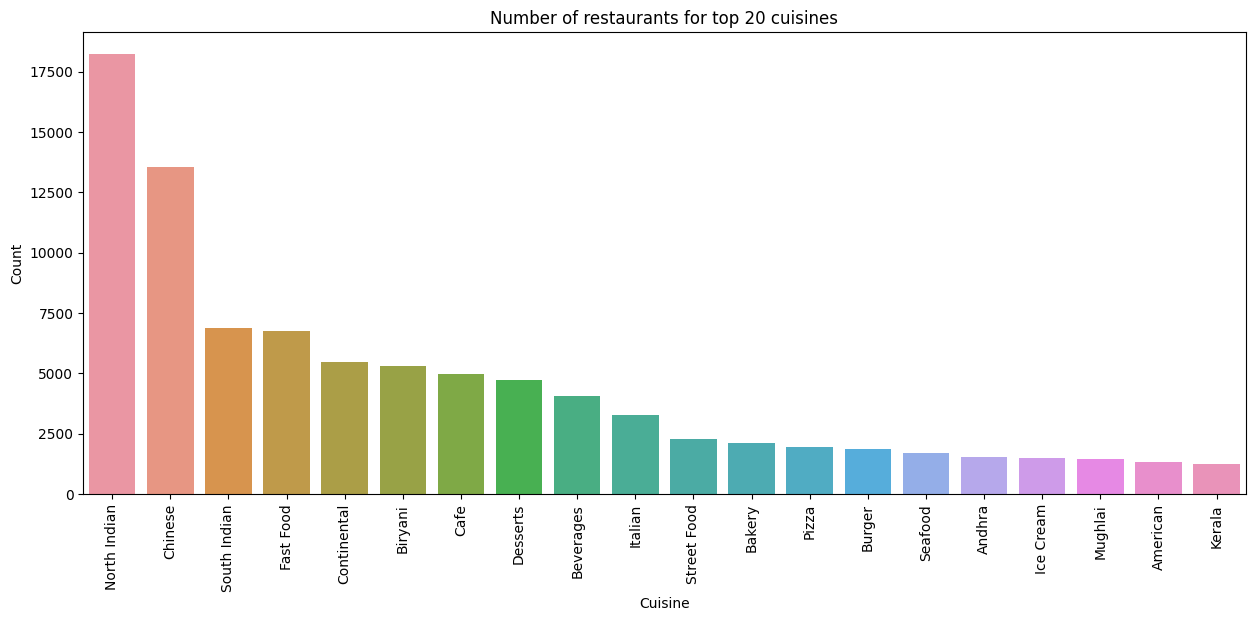

In [23]:
cuisine_popularity_df = cuisine_popularity_df.sort_values(by=['Count'], ascending=False)
cuisine_popularity_df = cuisine_popularity_df.reset_index()
cuisine_popularity_df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df[:20],x = 'Cuisine', y='Count')
plt.title('Number of restaurants for top 20 cuisines')
plt.xticks(rotation=90)
plt.show()

##### The graph below is plotted fromn the original cuisines column and we can see the difference in the results

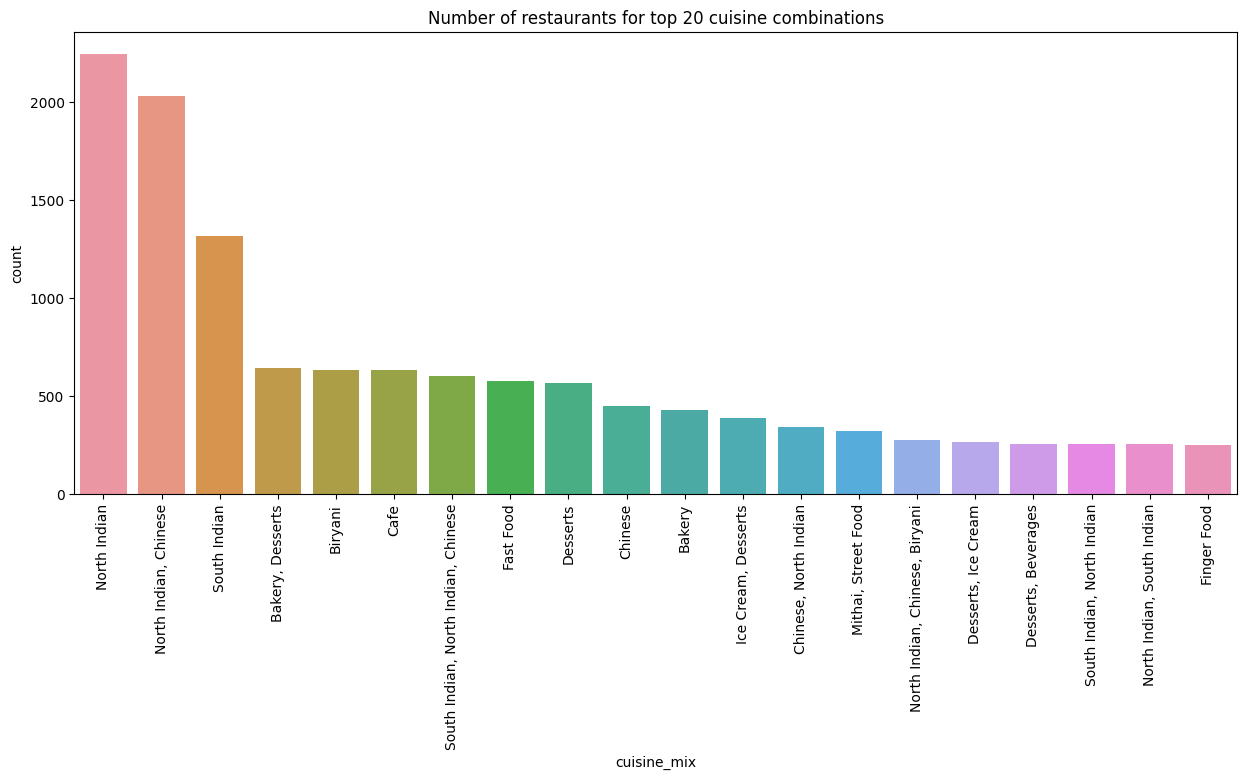

In [24]:
rest_data_mix_cuisine_top = rest_data['cuisines'].value_counts()[:20].rename_axis('cuisine_mix').reset_index(name='count')

plt.figure(figsize=(15,6))
sns.barplot(data=rest_data_mix_cuisine_top,x = 'cuisine_mix', y='count')
plt.title('Number of restaurants for top 20 cuisine combinations')
plt.xticks(rotation=90)
plt.show()

#### Now we look at the distribution of ratings across the top 20 cuisines

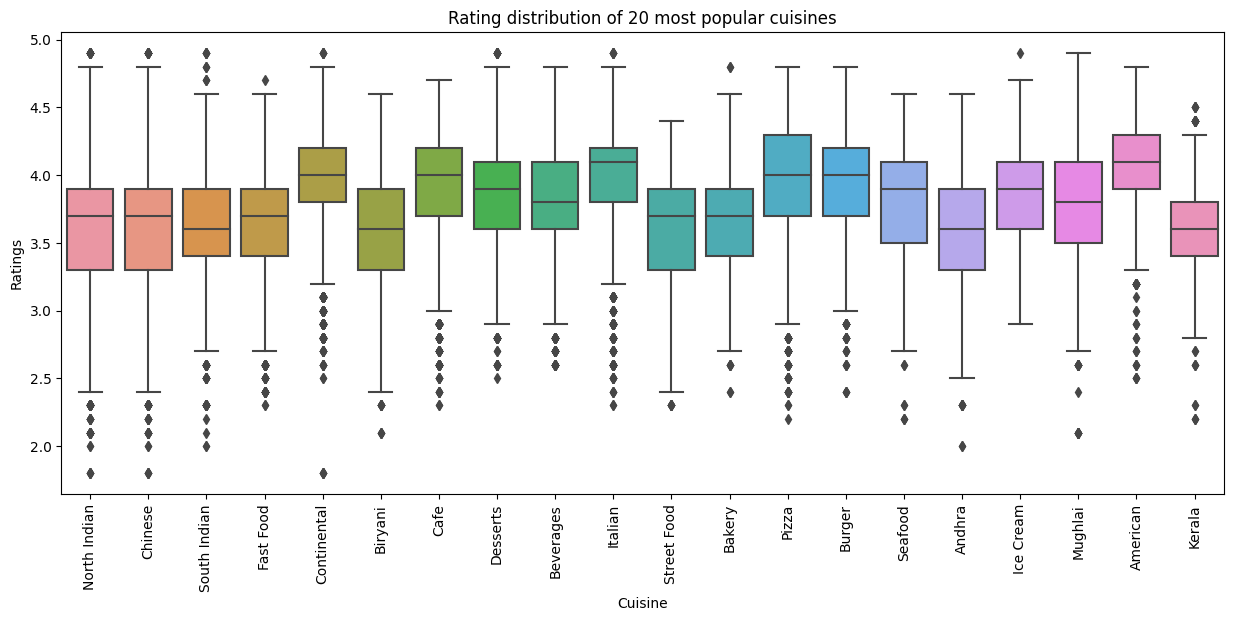

In [25]:
unique_cuisine_top = list(cuisine_popularity_df.head(20)['Cuisine'])
rate_data = []

for cuisine in unique_cuisine_top:
    cuisine_df = globals()['{}_df'.format(cuisine.replace(' ', ''))]
    rate_data.append(cuisine_df['rate'].dropna().tolist())

plt.figure(figsize=(15,6))
sns.boxplot(rate_data)

plt.xticks(range(0, len(unique_cuisine_top)), unique_cuisine_top, rotation=90)
plt.ylabel('Ratings')
plt.xlabel('Cuisine')
plt.title('Rating distribution of 20 most popular cuisines')
plt.show()

##### Distribution of votes across restaurants

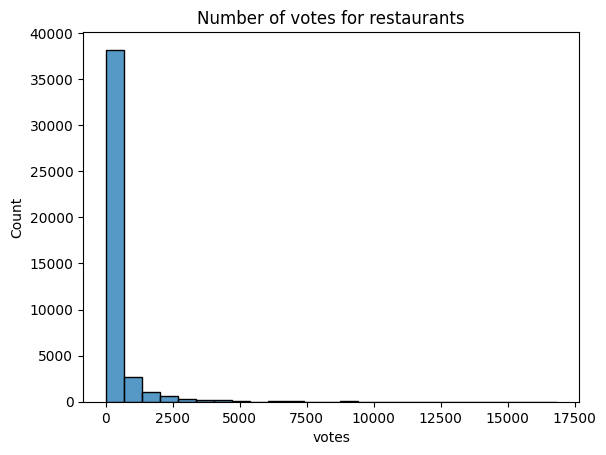

In [26]:
sns.histplot(rest_data['votes'],bins=25)
plt.title('Number of votes for restaurants')
plt.show()

### Building the Ideal Restaurant (Preliminary Approach)

In [27]:
#Aryan Approach
#Location: Most restaurants (Great place to set up as there is demand)
#Cuisine: Highest rated cuisine in that area
#Type: Highest rated type of restaurant in the area
#Budget: Highest rated 'budget-group'

#Mallory Approach
#Location: Highest rated location in the city
#Cuisine: Most popular cuisine in that location
#Type: Most popular type in that cuisine
#Budget: Most popular price_range in that budget

In [28]:
#Finds the location with most restaurants
location1 = rest_data['listed_in(city)'].value_counts().index[0]
location2 = rest_data.groupby('listed_in(city)')['rate'].mean().idxmax()


In [29]:
#Finds the relevant cuisines
cuisine1 = rest_data[rest_data['listed_in(city)'] == location1].groupby('cuisines')['rate'].mean().idxmax()
cuisine2 = rest_data[rest_data['listed_in(city)'] == location2]['cuisines'].value_counts().index[0]

In [30]:
#Finds the ideal restaurant types
type1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1)].groupby('listed_in(type)')['rate'].mean().idxmax()
type2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2)]['listed_in(type)'].value_counts().index[0]

In [31]:
#Finds the ideal price range
price_range1 = rest_data[(rest_data['listed_in(city)'] == location1) & (rest_data['cuisines'] == cuisine1) & (rest_data['listed_in(type)'] == type1)].groupby('price_range')['rate'].mean().idxmax()
price_range2 = rest_data[(rest_data['listed_in(city)'] == location2) & (rest_data['cuisines'] == cuisine2) & (rest_data['listed_in(type)'] == type2)]['price_range'].value_counts().index[0]

In [32]:
print('Our Preliminary Answers:\n')
print('Aryan:')
print('Location:',location1)
print('Cuisine:',cuisine1)
print('Type:',type1)
print('Price Range:',price_range1)
print('\n')
print('Mallory:')
print('Location:',location2)
print('Cuisine:',cuisine2)
print('Type:',type2)
print('Price Range:',price_range2)

Our Preliminary Answers:

Aryan:
Location: BTM
Cuisine: Asian, Chinese, Thai, Momos
Type: Buffet
Price Range: $$$$


Mallory:
Location: Church Street
Cuisine: North Indian
Type: Delivery
Price Range: $$


##### These are the 4 highest restaurants (all rated 4.9) in Bangalore (sorted by votes)
###### Byg Brewski Brewing Company - Sarjapur Road - Continental, North Indian, Italian, South Indian, Finger Food - Drinks & Nightlife - $$$$
###### Absolute Barbecues - European, Mediterranean, North Indian, BBQ - Kormangala 7th Block - Buffet - $$$$
###### Flechazgo - White Field - Asian, Mediterranean, North Indian, BBQ - Dine Out - $$$$
###### Asia Kitchen - Koramangala 7th Block - Asian, Chinese, Thai, Momos - Dine Out - $$$$

We see that there is significant variance in the 4 restaurants (except the price range being \\$\\$\\$\\$), therefore this highlights the issue of there not being a direct answer to this problem statement. This is something that we need to keep in consideration throughout that project that there is no one-size-fits all restaurant that is going to be successful. 

##### Finding the 90th perecentile of rating to define a "successful restaurant rating" for our success metric in the later stages of project

In [33]:
rest_data['rate'].quantile(0.9)

4.2

### Type Hunt

In [34]:
rest_data['name'] = rest_data['name'].astype("string")
rest_data['address'] = rest_data['address'].astype("string")
rest_data['url'] = rest_data['url'].astype("string")
rest_data['online_order'] = rest_data['online_order'].astype("string")
rest_data['book_table'] = rest_data['book_table'].astype("string")
rest_data['phone'] = rest_data['phone'].astype("string")
rest_data['location'] = rest_data['location'].astype("string")
rest_data['rest_type'] = rest_data['rest_type'].astype("string")
rest_data['dish_liked'] = rest_data['dish_liked'].astype("string")
rest_data['cuisines'] = rest_data['cuisines'].astype("string")
rest_data['reviews_list'] = rest_data['reviews_list'].astype("string")
rest_data['listed_in(type)'] = rest_data['listed_in(type)'].astype("string")
rest_data['listed_in(city)'] = rest_data['listed_in(city)'].astype("string")
rest_data['cuisines_list'] = rest_data['cuisines_list'].astype("string")
rest_data['cuisine_1'] = rest_data['cuisine_1'].astype("string")
rest_data['cuisine_2'] = rest_data['cuisine_2'].astype("string")
rest_data['cuisine_3'] = rest_data['cuisine_3'].astype("string")
rest_data['cuisine_4'] = rest_data['cuisine_4'].astype("string")
rest_data['cuisine_5'] = rest_data['cuisine_5'].astype("string")
rest_data['cuisine_6'] = rest_data['cuisine_6'].astype("string")
rest_data['cuisine_7'] = rest_data['cuisine_7'].astype("string")
rest_data['cuisine_8'] = rest_data['cuisine_8'].astype("string")
rest_data['price_range'] = rest_data['price_range'].astype("string")

We observe in the data that each restaurant has multiple entries. For example if restaurant A has Buffet, Dineout and Delivery and delivers to 2 locations (Jayanagar, JP nagar) then it will have 6 (3*2) rows.
This would lead to a biased dataset as restaurants that offer differnt types and deliver to a lot of locations will dominate the findings.

To avoid this, we create a new dataframe that has only 1 row per restaurant.

In [35]:
pivot_df = rest_data.pivot_table(index=['address','name','location','rate','cuisines','price_range','approx_cost(for two people)'], columns='listed_in(type)', aggfunc='count', fill_value=0)
pivot_df.columns = pivot_df.columns.get_level_values(1)
listed_in_type_df = pivot_df.reset_index()

In [36]:
res_type_df = listed_in_type_df.iloc [:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

In [37]:
print("The median rating from the new dataset is:",res_type_df['rate'].median())
print("The median rating from the original dataset is:",rest_data['rate'].median())

The median rating from the new dataset is: 3.7
The median rating from the original dataset is: 3.7


In [38]:
col_for_conversion = ['Buffet','Cafes','Delivery','Drinks & nightlife','Dine-out','Pubs and bars','Desserts']
res_type_df[col_for_conversion] = res_type_df[col_for_conversion].applymap(lambda x: 1 if x >= 1 else 0)

C:\Users\aryan\AppData\Local\Temp\ipykernel_7616\3066083276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_type_df[col_for_conversion] = res_type_df[col_for_conversion].applymap(lambda x: 1 if x >= 1 else 0)


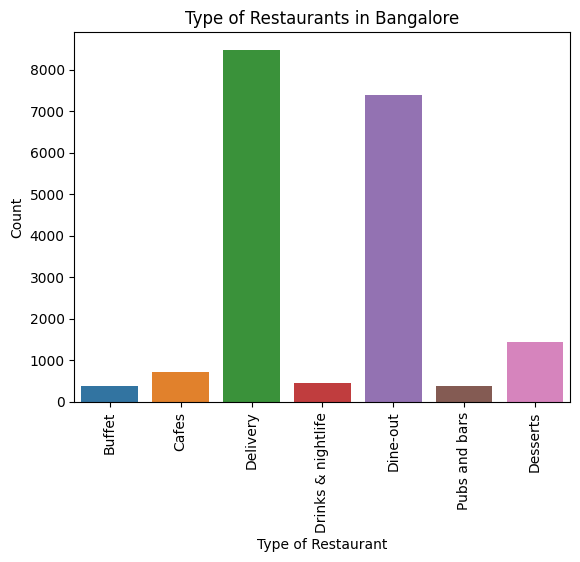

In [39]:
res_type_df_plot = res_type_df[col_for_conversion]

sum_of_1s = res_type_df_plot.sum(axis=0)
sns.barplot(x = col_for_conversion, y = sum_of_1s)

plt.xlabel('Type of Restaurant')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Type of Restaurants in Bangalore')
plt.show()

We see that Delivery and Dine-Out dominate as these are more broader categories when compared to others. Among the more specific categories, we see that Bangalore has a considerable amount of "Dessert" restaurants.

It is important to note that a restaurant listed as "Cafe" would also fall under "Dine-Out" (and possibly "Delivery"). Additionally, we also have restaurants that are more generic that would just be listed as "Dine-Out"

In [40]:
Buffet_df = res_type_df[res_type_df['Buffet']==1].iloc[:,[0,1,2,3,4,5,6]]
Cafes_df = res_type_df[res_type_df['Cafes']==1].iloc[:,[0,1,2,3,4,5,6]]
Dessert_df = res_type_df[res_type_df['Desserts']==1].iloc[:,[0,1,2,3,4,5,6]]
Dineout_df = res_type_df[res_type_df['Dine-out']==1].iloc[:,[0,1,2,3,4,5,6]]
DrinksAndNightlife_df = res_type_df[res_type_df['Drinks & nightlife']==1].iloc[:,[0,1,2,3,4,5,6]]
PubsAndBars_df = res_type_df[res_type_df['Pubs and bars']==1].iloc[:,[0,1,2,3,4,5,6]]

Buffet_df = Buffet_df.iloc[:,[0,1,2,3,4,5,6]]
Cafes_df = Cafes_df.iloc[:,[0,1,2,3,4,5,6]]
Dessert_df = Dessert_df.iloc[:,[0,1,2,3,4,5,6]]
Dineout_df = Dineout_df.iloc[:,[0,1,2,3,4,5,6]]
DrinksAndNightlife_df = DrinksAndNightlife_df.iloc[:,[0,1,2,3,4,5,6]]
PubsAndBars_df = PubsAndBars_df.iloc[:,[0,1,2,3,4,5,6]]


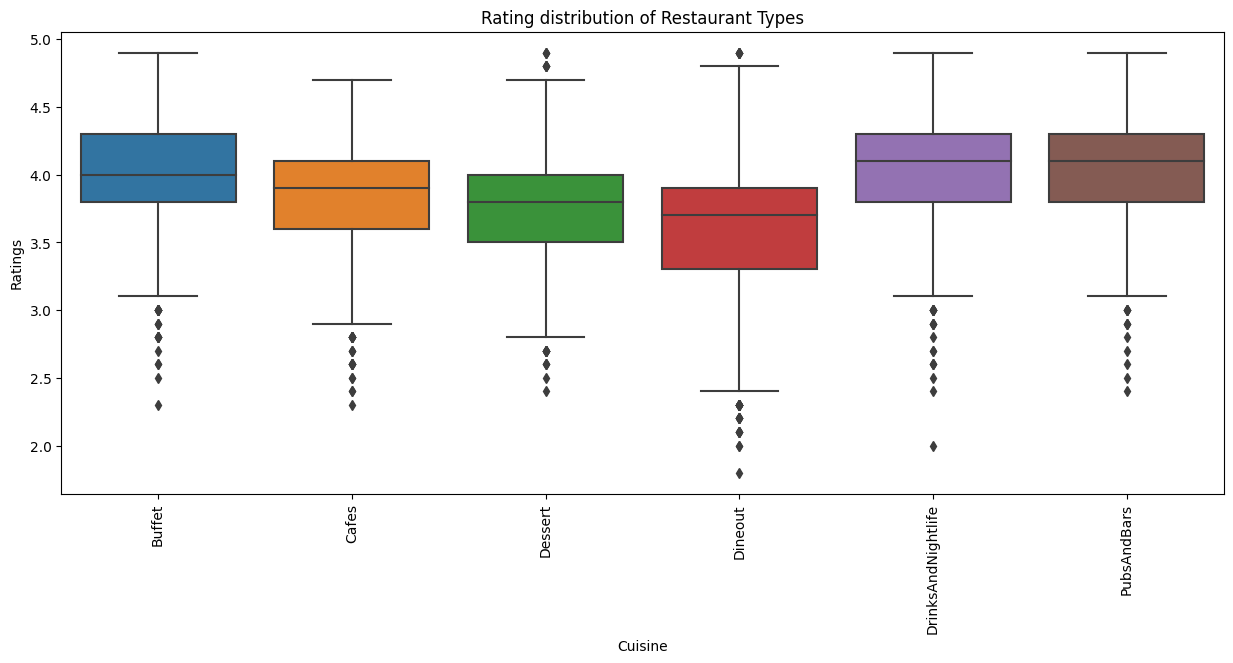

In [41]:
rate_type_data = []
res_type_df1 = res_type_df.copy()
res_type_list = ['Buffet','Cafes','Dessert','Dineout','DrinksAndNightlife','PubsAndBars']

for type in res_type_list:
    res_type_df = globals()['{}_df'.format(type.replace(' ', ''))]
    rate_type_data.append(res_type_df['rate'].dropna().tolist())

plt.figure(figsize=(15,6))
sns.boxplot(rate_type_data)

plt.xticks(range(0, len(res_type_list)), res_type_list, rotation=90)
plt.ylabel('Ratings')
plt.xlabel('Cuisine')
plt.title('Rating distribution of Restaurant Types')
plt.show()

Some important observations we make:
1. Drinks&Nightlife and Pubs&Bars and Buffets are generally rated higher than other restaurant types.
2. Drinks&Nightlife and Pubs&Bars have very similar distributions which could be possibly because both could be used almost interchangebly in most scenarios (We would confirm this hypothesis later down the line using statistical tests).
3. Even though Desserts are a common restaurant type they do not fare as well with the population.

#### Confounder Analysis

Between the 3 top rated restaurant types (Drinks&Nightlife and Pubs&Bars and Buffets), we would like to choose one. For this we look at any potential confounders that could be there that could be bringing upon these higher ratings and can they be accounted for.

Since we believe that Pubs&Bars and Drinks$Nightlife refer to the same restaurants we will compare Buffets and Drinks&Nightlife using potential outcomes.

##### The confounder that we want to account for is: Approx cost for 2

We will have these 3 random variables for our analysis:
- r: ratings
- t: restaurant type (t=1: Buffets, t=0: Drinks&Nightlife)
- c: cost (c=1: cost is $$$$, c=0: cost is lower than that)


Looking at the unadjusted ATE, we would have $\mu_r|_t(1) - \mu_r|_t(0)$

In [42]:
unadjusted_ATE_cost = res_type_df1[res_type_df1['Buffet']==1]['rate'].mean() - res_type_df1[res_type_df1['Drinks & nightlife']==1]['rate'].mean()
print('The Observed Unadjusted ATE is',unadjusted_ATE_cost)

The Observed Unadjusted ATE is -0.010950948149184292


This tells us that Drinks&Nightlife restaurants are slightly more higher rated than Buffet restaurants. We will now factor in the expensive angle, to see if the higher rating is down to Drinks&Nigtlife restaurants being more posh.

Adjusted ATE = E[po<sub>1</sub>] - E[po<sub>0</sub>] = E[$\mu$<sub>po1|c</sub>(c)] - E[$\mu$<sub>po0|c</sub>(c)]

In [43]:
pc1 = ((res_type_df1[res_type_df1['price_range']=='$$$$']).shape[0]) / (res_type_df1.shape[0])
pc0 = 1 - pc1

In [44]:
E_po1 = (res_type_df1[(res_type_df1['price_range']=='$$$$') & (res_type_df1['Buffet']==1)]['rate'].mean())*pc1 + (res_type_df1[(res_type_df1['price_range']!='$$$$') & (res_type_df1['Buffet']==1)]['rate'].mean())*pc0
E_po0 = (res_type_df1[(res_type_df1['price_range']=='$$$$') & (res_type_df1['Drinks & nightlife']==1)]['rate'].mean())*pc1 + (res_type_df1[(res_type_df1['price_range']!='$$$$') & (res_type_df1['Drinks & nightlife']==1)]['rate'].mean())*pc0
print('The Adjusted ATE is', E_po1 - E_po0)

The Adjusted ATE is 0.22212103558912188


After adjusting for the confunder (cost for two), we see that buffets would be a better rated restaurant overall category. If we are setting up a expensive restaurant, we would go with Drinks & Nightlife.

This also shows us that our dataset had evidence of Simpsons Paradox, which was now accounted for thanks to potential outcomes.

#### <b>Important Inference Made</b>: 
#### If very expensive restaurant, go with Drinks and Nighlife. If not, go with Buffets.

We mentioned the fact that if there is a high end restaurant, than we should go with Drinks & Nightlife, whereas for a low budget one, it would be better to go with Buffets. 
<br>
What we saw earlier was that the top 5 restaurants in Bangalore (in terms of ratings), were in the '\\$\\$\\$\\$' price category. This brings up the question: <b>Do we even go with a lower end restaurant?</b>

<AxesSubplot: xlabel='price_range_num', ylabel='rate'>

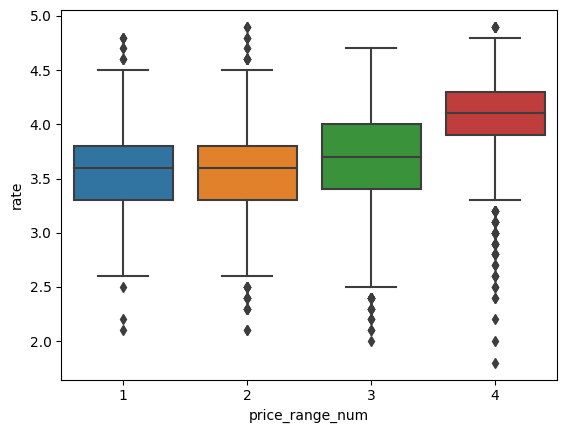

In [45]:
res_type_df2 = res_type_df1.copy()
price_dict = {'$$$$': 4, '$$$': 3, '$$': 2, '$': 1}
res_type_df2['price_range_num'] = res_type_df2['price_range'].apply(lambda x: price_dict.get(x))
sns.boxplot(x='price_range_num', y='rate', data = res_type_df2)

We see that getting to a very high rating is much harder for lower budget restaurants. This however does not mean that those restaurants would not be successful, but in our framework where success is a proxy for ratings it would not be in our interests to go with them. One could go with a restaurant that is \\$\\$\\$ and have it be very successful (25% restaurants in that category are rated higher than the 90 percentile rating).
<br>
<br>
Another important inference we get is that not all '\\$\\$\\$\\$' rated restaurants are highly rated. Only 50% of the restaurants lie above the 90 percentile mark. This warrants the need for this project even more to try and find ideal configurations.

### Important Inference (Refined):
If you are opening a restaurant in the \\$\\$\\$\\$ price range, go with: Drinks & Nightlife
<br>
If you are opening a restaurant in the \\$\\$\\$ price range, go with: Buffets

### What if I don't want to open a Buffet/Drinks & Nightlife restaurant?

Let us say that one does not want to open either of those restaurants. You seem to think that Buffets are not profitable or Drinks & Nightlife does not align with your philosophy of a restaurant, then what?
<br>
We also highlighted the fact before that the 5 types were just niches and a whole array of retaurants fell under 'Dining' and consequently 'Delivery'. 
<br>
<br>
Looking at both these aspects, we now look forward to answering the cuisine question. This along with jnowledge about the location will help us appeal to a broader audience looking to open restaurants in Bangalore under a more generic Dining umbrella.

### Cuisine Hunt

We already looked at cuisine ratings. What we had found above, was the ratings distribution of the top 20 cuisines in Bangalore. 
Before making a conclusion and analysing the best rated 2-3 cuisines, we would first like to look at the distribution of cusines across the 5 most popular locations in Bangalore.

In [46]:
rest_data['location'].value_counts().index[0:5]

Index(['BTM', 'Koramangala 5th Block', 'HSR', 'Indiranagar', 'JP Nagar'], dtype='string')

We look at the top 10 most popular cuisines as once we get to a location level, the count of restaurants of a specific cuisine severly decrease. So the top 10 are the only ones that would have some significance at this level.
We can later look and compare our finidings with the overall graph, if we think that some cuisine needs special attention as it extremely high rated.

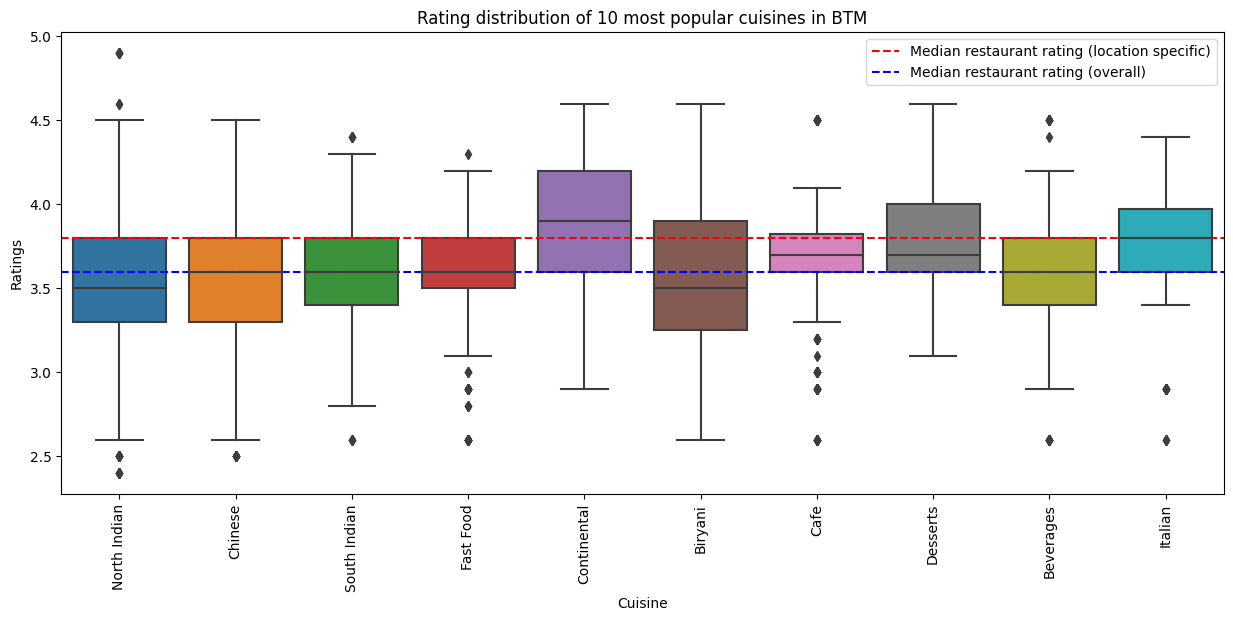

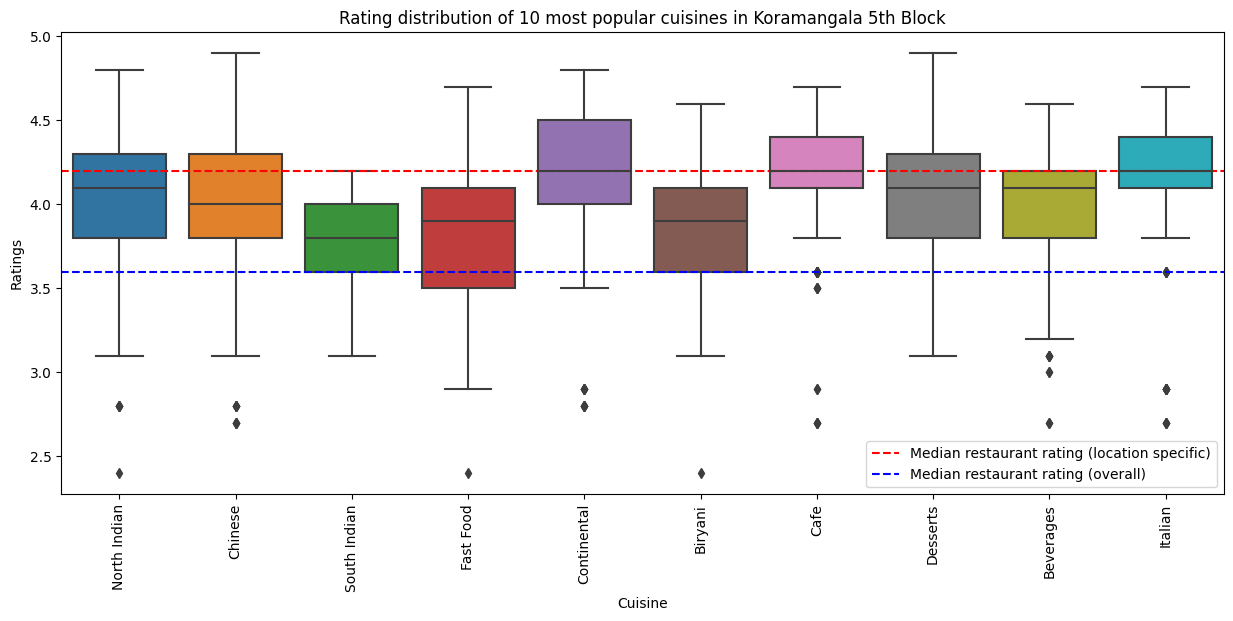

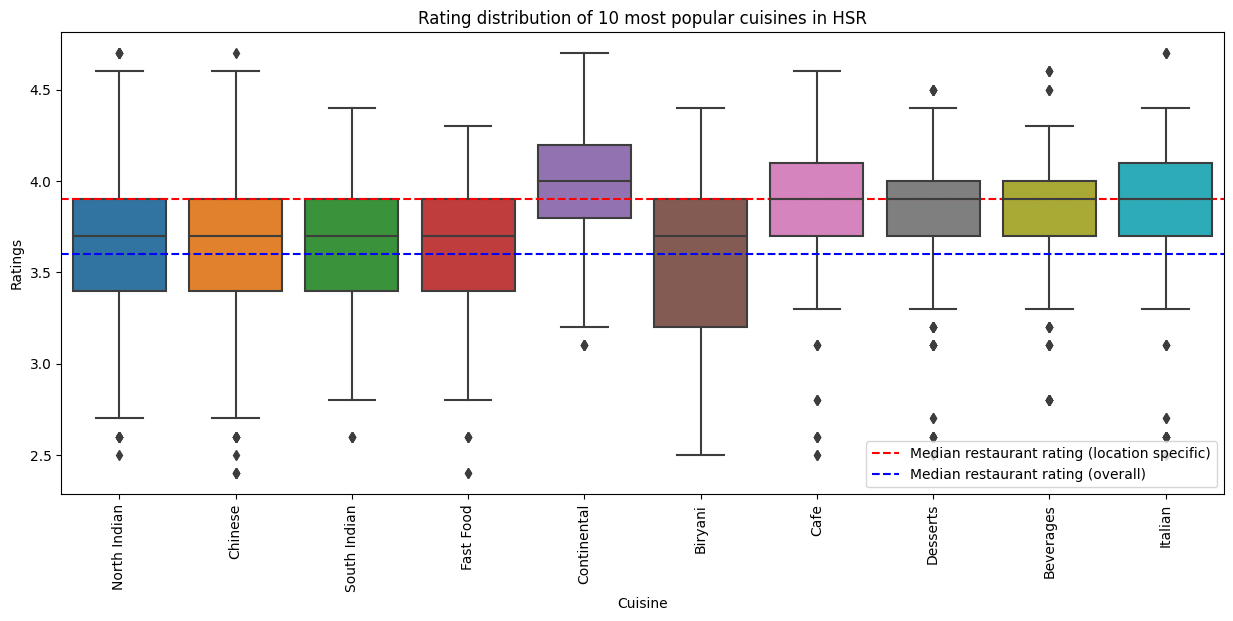

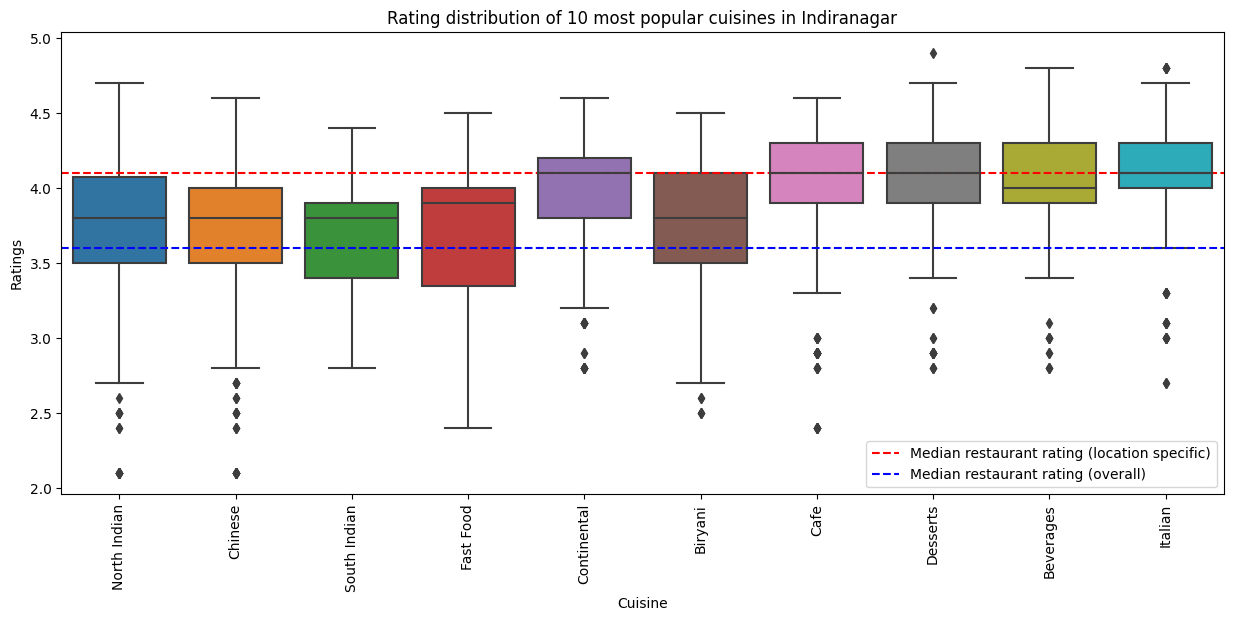

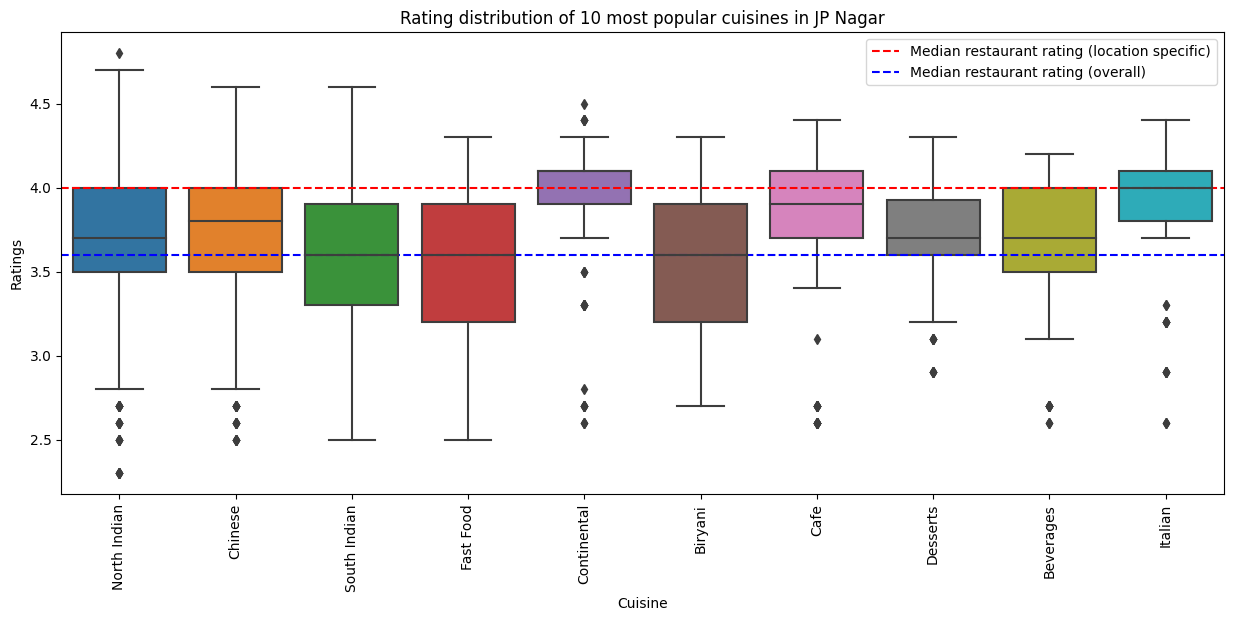

In [47]:
unique_cuisine_top = list(cuisine_popularity_df.head(10)['Cuisine'])
location_data = ['BTM', 'Koramangala 5th Block', 'HSR', 'Indiranagar', 'JP Nagar']
cuisine_df1 = cuisine_df.copy()

for loc in location_data:
    rate_data = []
    for cuisine in unique_cuisine_top:
        cuisine_df = globals()['{}_df'.format(cuisine.replace(' ', ''))]
        rate_data.append(cuisine_df[cuisine_df['location'] == loc]['rate'].dropna().tolist())

    plt.figure(figsize=(15,6))
    sns.boxplot(rate_data)
    plt.axhline(cuisine_df[cuisine_df['location'] == loc]['rate'].median(),color = 'r', linestyle = 'dashed', label = "Median restaurant rating (location specific)")
    plt.axhline(cuisine_df1['rate'].median(),color = 'b', linestyle = 'dashed', label = "Median restaurant rating (overall)")

    plt.xticks(range(0, len(unique_cuisine_top)), unique_cuisine_top, rotation=90)
    plt.legend()
    plt.ylabel('Ratings')
    plt.xlabel('Cuisine')
    plt.title('Rating distribution of 10 most popular cuisines in ' + str(loc))

In [48]:
cuisine_popularity_df_10 = cuisine_popularity_df[:10]
cuisine_popularity_df_10['% Count'] = cuisine_popularity_df_10['Count']/cuisine_popularity_df_10['Count'].sum()

C:\Users\aryan\AppData\Local\Temp\ipykernel_7616\2758890378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cuisine_popularity_df_10['% Count'] = cuisine_popularity_df_10['Count']/cuisine_popularity_df_10['Count'].sum()


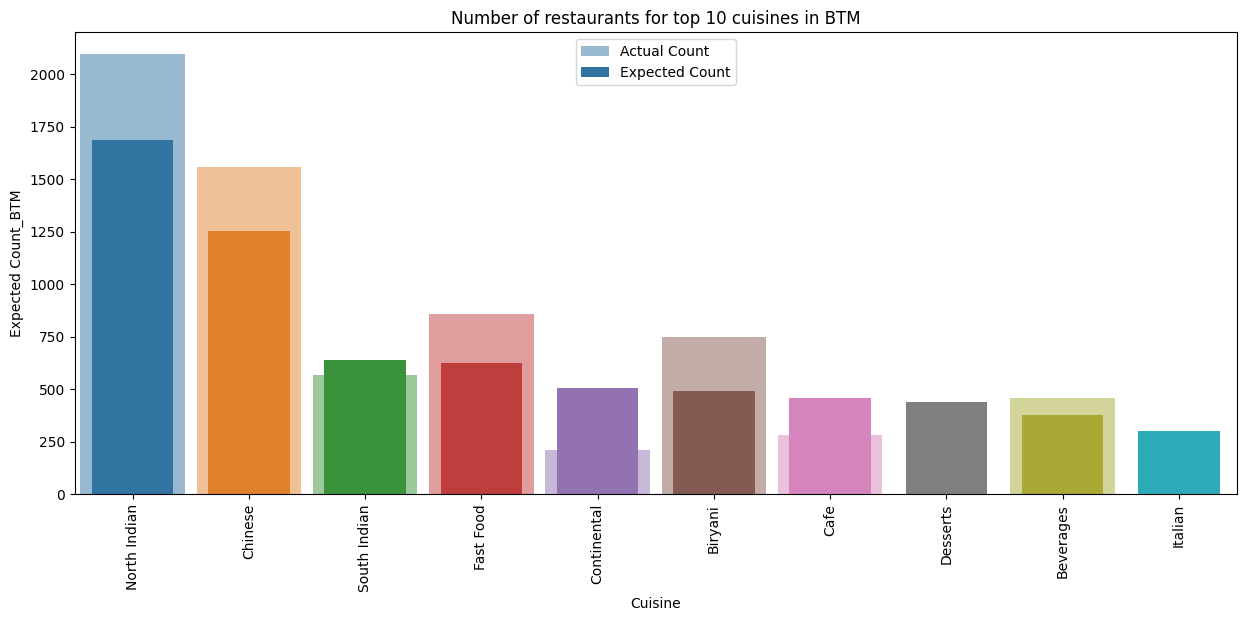

In [49]:
cuisine_count_list_BTM = []
for i in range(len(unique_cuisines)):
    rows = rest_data[((rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])) 
                     & (rest_data['location'] == 'BTM')].index
    cuisine_df_BTM = rest_data.iloc[rows]
    cuisine_count_list_BTM.append(len(cuisine_df_BTM))
    df_name = '{}_btm_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df_BTM

cuisine_popularity_df_BTM = pd.DataFrame()
cuisine_popularity_df_BTM['Cuisine'] = unique_cuisines
cuisine_popularity_df_BTM['Count_BTM'] = cuisine_count_list_BTM

cuisine_popularity_df_BTM = cuisine_popularity_df_BTM.sort_values(by=['Count_BTM'], ascending=False)
cuisine_popularity_df_BTM = cuisine_popularity_df_BTM.reset_index()
cuisine_popularity_df_BTM.drop('index',axis=1,inplace=True)

cuisine_popularity_df_BTM_10 = cuisine_popularity_df_BTM[:10]
cuisine_popularity_df_BTM_10 = cuisine_popularity_df_10.merge(cuisine_popularity_df_BTM_10, how='left')
cuisine_popularity_df_BTM_10['Expected Count_BTM'] = cuisine_popularity_df_BTM_10['Count_BTM'].sum()*cuisine_popularity_df_BTM_10['% Count']
plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df_BTM_10,x = 'Cuisine', y='Count_BTM', width = 0.9, alpha = 0.5, label='Actual Count')
sns.barplot(data=cuisine_popularity_df_BTM_10,x = 'Cuisine', y='Expected Count_BTM', width = 0.7, label='Expected Count')
plt.legend()
plt.title('Number of restaurants for top 10 cuisines in BTM')
plt.xticks(rotation=90)
plt.show()

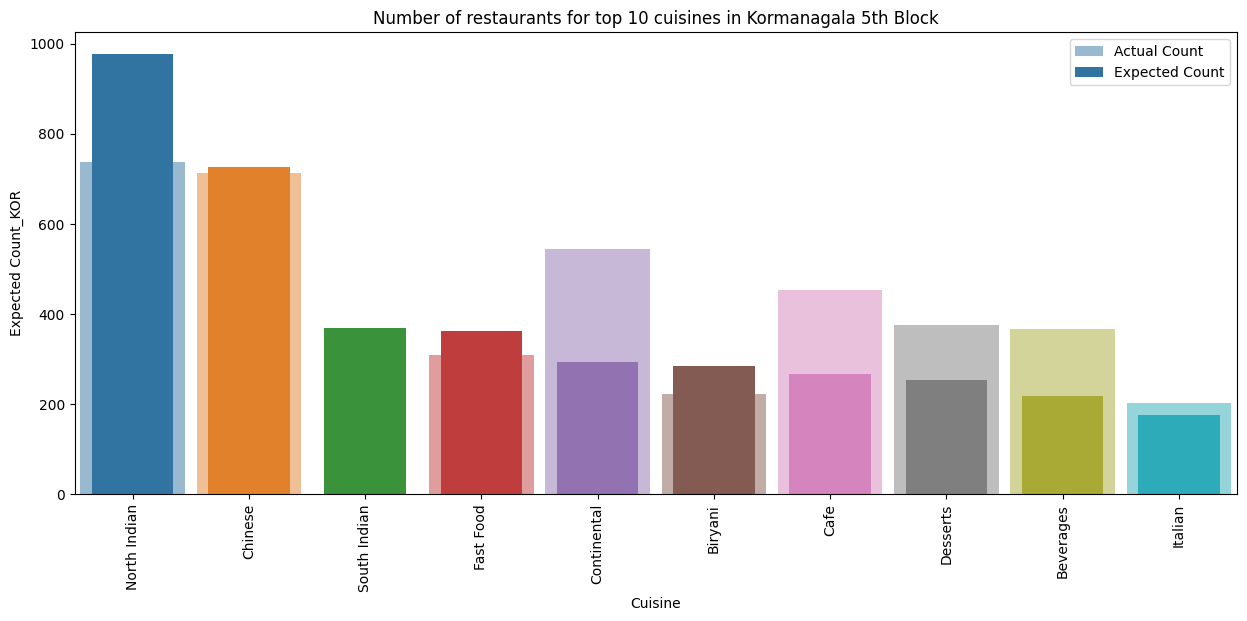

In [50]:
cuisine_count_list_KOR = []
for i in range(len(unique_cuisines)):
    rows = rest_data[((rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])) 
                     & (rest_data['location'] == 'Koramangala 5th Block')].index
    cuisine_df_KOR = rest_data.iloc[rows]
    cuisine_count_list_KOR.append(len(cuisine_df_KOR))
    df_name = '{}_kor_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df_KOR

cuisine_popularity_df_KOR = pd.DataFrame()
cuisine_popularity_df_KOR['Cuisine'] = unique_cuisines
cuisine_popularity_df_KOR['Count_KOR'] = cuisine_count_list_KOR

cuisine_popularity_df_KOR = cuisine_popularity_df_KOR.sort_values(by=['Count_KOR'], ascending=False)
cuisine_popularity_df_KOR = cuisine_popularity_df_KOR.reset_index()
cuisine_popularity_df_KOR.drop('index',axis=1,inplace=True)

cuisine_popularity_df_KOR_10 = cuisine_popularity_df_KOR[:10]
cuisine_popularity_df_KOR_10 = cuisine_popularity_df_10.merge(cuisine_popularity_df_KOR_10, how='left')
cuisine_popularity_df_KOR_10['Expected Count_KOR'] = cuisine_popularity_df_KOR_10['Count_KOR'].sum()*cuisine_popularity_df_KOR_10['% Count']
plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df_KOR_10,x = 'Cuisine', y='Count_KOR', width = 0.9, alpha = 0.5, label='Actual Count')
sns.barplot(data=cuisine_popularity_df_KOR_10,x = 'Cuisine', y='Expected Count_KOR', width = 0.7, label='Expected Count')
plt.legend()
plt.title('Number of restaurants for top 10 cuisines in Kormanagala 5th Block')
plt.xticks(rotation=90)
plt.show()

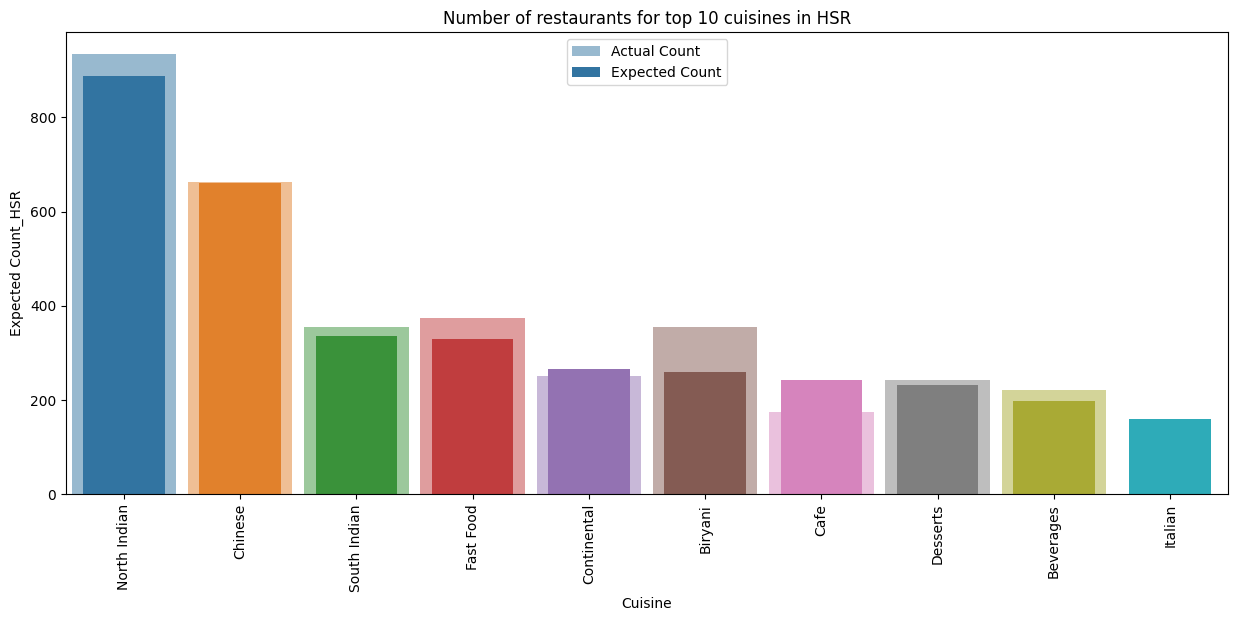

In [51]:
cuisine_count_list_HSR = []
for i in range(len(unique_cuisines)):
    rows = rest_data[((rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])) 
                     & (rest_data['location'] == 'HSR')].index
    cuisine_df_HSR = rest_data.iloc[rows]
    cuisine_count_list_HSR.append(len(cuisine_df_HSR))
    df_name = '{}_hsr_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df_HSR

cuisine_popularity_df_HSR = pd.DataFrame()
cuisine_popularity_df_HSR['Cuisine'] = unique_cuisines
cuisine_popularity_df_HSR['Count_HSR'] = cuisine_count_list_HSR

cuisine_popularity_df_HSR = cuisine_popularity_df_HSR.sort_values(by=['Count_HSR'], ascending=False)
cuisine_popularity_df_HSR = cuisine_popularity_df_HSR.reset_index()
cuisine_popularity_df_HSR.drop('index',axis=1,inplace=True)

cuisine_popularity_df_HSR_10 = cuisine_popularity_df_HSR[:10]
cuisine_popularity_df_HSR_10 = cuisine_popularity_df_10.merge(cuisine_popularity_df_HSR_10, how='left')
cuisine_popularity_df_HSR_10['Expected Count_HSR'] = cuisine_popularity_df_HSR_10['Count_HSR'].sum()*cuisine_popularity_df_HSR_10['% Count']
plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df_HSR_10,x = 'Cuisine', y='Count_HSR', width = 0.9, alpha = 0.5, label='Actual Count')
sns.barplot(data=cuisine_popularity_df_HSR_10,x = 'Cuisine', y='Expected Count_HSR', width = 0.7, label='Expected Count')
plt.legend()
plt.title('Number of restaurants for top 10 cuisines in HSR')
plt.xticks(rotation=90)
plt.show()

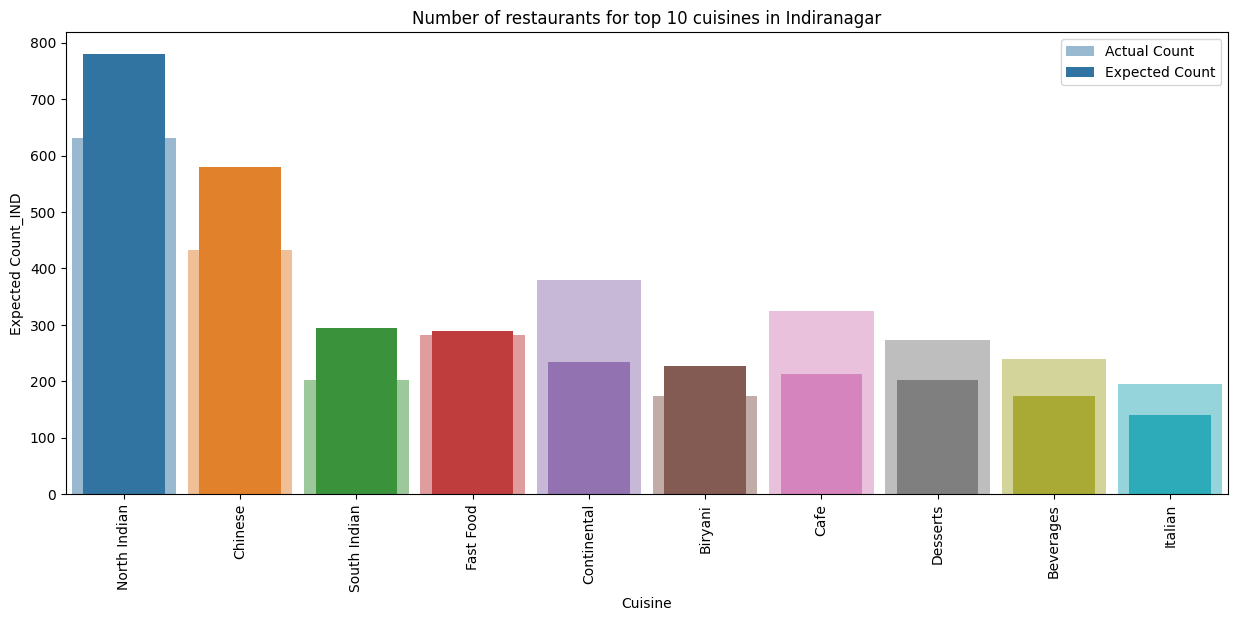

In [52]:
cuisine_count_list_IND = []
for i in range(len(unique_cuisines)):
    rows = rest_data[((rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])) 
                     & (rest_data['location'] == 'Indiranagar')].index
    cuisine_df_IND = rest_data.iloc[rows]
    cuisine_count_list_IND.append(len(cuisine_df_IND))
    df_name = '{}_ind_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df_IND

cuisine_popularity_df_IND = pd.DataFrame()
cuisine_popularity_df_IND['Cuisine'] = unique_cuisines
cuisine_popularity_df_IND['Count_IND'] = cuisine_count_list_IND

cuisine_popularity_df_IND = cuisine_popularity_df_IND.sort_values(by=['Count_IND'], ascending=False)
cuisine_popularity_df_IND = cuisine_popularity_df_IND.reset_index()
cuisine_popularity_df_IND.drop('index',axis=1,inplace=True)

cuisine_popularity_df_IND_10 = cuisine_popularity_df_IND[:10]
cuisine_popularity_df_IND_10 = cuisine_popularity_df_10.merge(cuisine_popularity_df_IND_10, how='left')
cuisine_popularity_df_IND_10['Expected Count_IND'] = cuisine_popularity_df_IND_10['Count_IND'].sum()*cuisine_popularity_df_IND_10['% Count']
plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df_IND_10,x = 'Cuisine', y='Count_IND', width = 0.9, alpha = 0.5, label='Actual Count')
sns.barplot(data=cuisine_popularity_df_IND_10,x = 'Cuisine', y='Expected Count_IND', width = 0.7, label='Expected Count')
plt.legend()
plt.title('Number of restaurants for top 10 cuisines in Indiranagar')
plt.xticks(rotation=90)
plt.show()

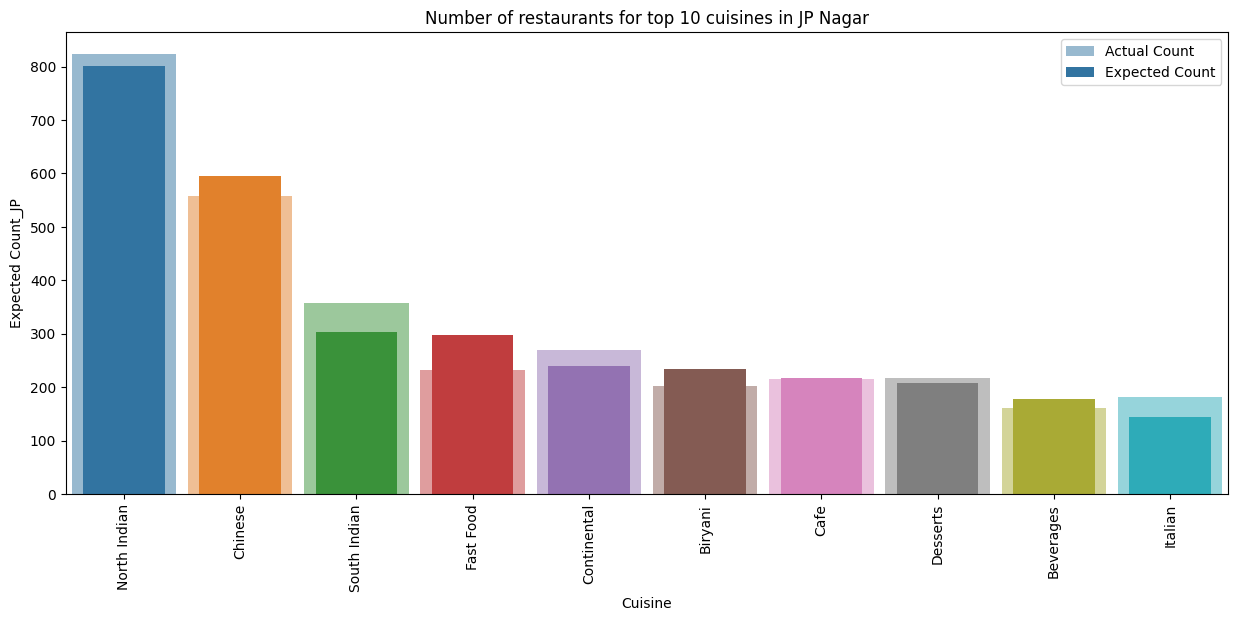

In [53]:
cuisine_count_list_JP = []
for i in range(len(unique_cuisines)):
    rows = rest_data[((rest_data['cuisine_1'] == unique_cuisines[i]) | (rest_data['cuisine_2'] == unique_cuisines[i]) 
                     | (rest_data['cuisine_3'] == unique_cuisines[i]) | (rest_data['cuisine_4'] == unique_cuisines[i])
                     | (rest_data['cuisine_5'] == unique_cuisines[i]) | (rest_data['cuisine_6'] == unique_cuisines[i])
                     | (rest_data['cuisine_7'] == unique_cuisines[i]) | (rest_data['cuisine_8'] == unique_cuisines[i])) 
                     & (rest_data['location'] == 'JP Nagar')].index
    cuisine_df_JP = rest_data.iloc[rows]
    cuisine_count_list_JP.append(len(cuisine_df_JP))
    df_name = '{}_jp_df'.format(unique_cuisines[i].replace(' ',''))
    globals()[df_name] = cuisine_df_JP

cuisine_popularity_df_JP = pd.DataFrame()
cuisine_popularity_df_JP['Cuisine'] = unique_cuisines
cuisine_popularity_df_JP['Count_JP'] = cuisine_count_list_JP

cuisine_popularity_df_JP = cuisine_popularity_df_JP.sort_values(by=['Count_JP'], ascending=False)
cuisine_popularity_df_JP = cuisine_popularity_df_JP.reset_index()
cuisine_popularity_df_JP.drop('index',axis=1,inplace=True)

cuisine_popularity_df_JP_10 = cuisine_popularity_df_JP[:10]
cuisine_popularity_df_JP_10 = cuisine_popularity_df_10.merge(cuisine_popularity_df_JP_10, how='left')
cuisine_popularity_df_JP_10['Expected Count_JP'] = cuisine_popularity_df_JP_10['Count_JP'].sum()*cuisine_popularity_df_JP_10['% Count']
plt.figure(figsize=(15,6))
sns.barplot(data=cuisine_popularity_df_JP_10,x = 'Cuisine', y='Count_JP', width = 0.9, alpha = 0.5, label='Actual Count')
sns.barplot(data=cuisine_popularity_df_JP_10,x = 'Cuisine', y='Expected Count_JP', width = 0.7, label='Expected Count')
plt.legend()
plt.title('Number of restaurants for top 10 cuisines in JP Nagar')
plt.xticks(rotation=90)
plt.show()

#### Inferences made with respect to Cuisine x Location:
* BTM
    * The people of this area generally rate the same as the rest of Bangalore.
    * We see that the top 2 highest rated restaurants in the area are North Indian (However, North Indian overall is not rated too special)
    * Italian restaurants seem to have less variablity so would make for a strong contender as well. However, we see that this is due to the fact that there are very few Italian restaurants in the area (so much so, that they don'teven show up significantly in the graph).
    * Continental restaurants seem to be our best answer here as they are rated the best and also have much fewwer restaurants than expected, so we can see that the market is not saturated.
<br>
<br>
* Kormangla 5th Block
    * We can infer that the people residing here are some of the most generous raters in the city.
    * We could argue that on the basis of ratings, there are multiple cuisines that do well: Continental, Cafes, Desserts, Italian and Indian.
    * However, when we look at the Actual v/s Expected graph, we see that 4 of the cuisines are extremely saturated and competitve.
    * North Indian restaurants would be a good bet here (or Chinese, but this could also be restaurant dependent as it has a high IQR).
<br>
<br>
* HSR
    * The people of this area tend to rate higher than the rest of Bangalore.
    * The 4 most popular cuisines do not perform great here, so it does not make sense to go with either of them.
    * On the basis of having low variablity, Cafes and Italian restaurants would be a good bet. However once again the same situatuon as BTM plays out for Italian Restaurants.
<br>
<br>
* Indiranagar
    * Even though people here tend to vote generously, none of the top 10 cuisines stand out to the eye. This would also indicate that there are cuisines outside of this bracket that are doing very well in this location.
    * The best cuisines would be Desserts and Italian based on their IQR, and where the 75-100 percentile range lies. 
    * Even though the market is competitve in those cuisines that would be the best options.
    * We also see that the median rating has the slightest fall (when compared to other locations) when we include the top 20 cuisines, implying their likeliness of other cuisines. This also follows through my knwoledge of the area as it has a very big "young population".
<br>
<br>
* JP Nagar
    * No cuisine is a stand out performer, irrespective of high ratings.
    * We also see that the Actual v/s Expected restaurants are pretty well distributed which follows domain knowledge as it is on of the oldest areas so most restaurants are pretty established and the area as a whole has reached saturation so it kind of centers to what is expected. (It is effectively a mini-Bangalore).
    * Even though North-Indian has the highest IQR, it still could give the best results if done right. However, Chinese would be a better pick as most of their parameters are the same but Chinese restaurants have a higher median.
    * A key thing to note here is that including the next 10 popular cuisines, results in the sharpest decline of median ratings implying that the people here would not be big fans of non-traditional restaurants.

### Important Inference:
BTM: Continental Cuisine
<br>
Kormanagla: North Indian Cuisine
<br>
HSR: Cafe
<br>
Indiranagar: Explore outside top 10 cuisines
<br>
JP Nagar: Chinese Cuisine
<br>
<br>
Best Area to open in: Continental Restaurant in BTM (high overall ratings, low competition)
<br>
Worst Area to open in (among the top 5): JP Nagar (Saturated market overall)

### Checking for Success
We look at restaurants opened post this dataset generation that suit our "ideal restaurant criteras". We come up with some interesting insights: 
<br>
<br>
We first look under the Continental Restaurants opened in BTM relatively recently. We find the ratings of these newly opened restaurants <b>(K-OS Game Bar: 4.5, Fogg Lounge: 4.4, Mudpipe Cafe: 4.2)</b>. Even thought the ratings of the first 2 would depend on other factors (High Price for 2, New concept (i.e. K-OS is a darts bar)), we see a lower price restaurant (Mudpipe Cafe) did succeed as well.
<br>
<br>
Not a lot of only North Indian restaurants were opened in recent times in Kormangla in the \\$\\$ and \\$\\$\\$ price range. We were able to find 2 <b>(Kathpals: 4.3, Jalandhar Street: 4.0)</b>. We would say, that this was a missed oppurtunity for potential investors.
<br>
<br>
We also look at recent Cafes opened up in HSR which are in the \\$\\$ and \\$\\$\\$ price range. On a general view, all of them seem to be rated above 3.9. Additionally we have a good chunk rated higher <b>(Hustle: 4.9, Burger Yard: 4.8, Cuppa Redefined: 4.5)</b> which shows that our analysis was on the right track. Infact it was a very big hit here as 2 of the cities highest rated restaurants are now cafes in HSR.
<br>
<br>
Since, we also looked at Buffets being a successful category, we look at recently opened buffets in the \\$\\$, \\$\\$\\$ section <b>(Kitchen De Buffet: 4.7, Maxims Buffet: 4.2, One Atria Cafe: 4.3, Zodiac: 4.0, The Buffet Table: 3.5)</b>. A lot more variablity here with what most people would call a "hit and miss", signifying that there are other factors that need to be taken in consideration as well.
<br>
NOTE: For Buffets, since we did not specify a location in the analysis, we looked at Buffets throughout Bangalore. Clearly location is a big factor as well which would account for a lot of this variance.

### Hypothesis Testing Time (Other Factors):
We also have access to the phone numbers of the restaurant. Numbers starting with +91 (Country code of India) belong to personal mobile phones whereas numbers starting with 080 (Area code of Bangalore) belong to landlines. We think that restaurants that have personal phones listed don't have a very organisational structural in place and would therefore suggest that they belong to a lower price range. As we know there is a correlation between rating and price range, it would suffice to say that they would be rated lower. 


#### Designing the Hypothesis Test:
Test Statistic (t) = median(personal_phone) - median(landline) <br>
H<sub>0</sub> : t = 0 <br>
H<sub>1</sub> : t > 0
<br>
<br>
Since we have flags (1 represents personal_phone and 0 represents landline), we can set it up as a permutation test where we effectively say that the label would not matter. Due to the number of values, it would not be computationally possible to do this. Therefore, we look to apply a monte-carlo approach.
<br>
<br>
<b>Note:</b> Restaurants that have both listed fall under the landline bracket as there, having a personal phone represents as providing additional convenience rather than lack of structure.

In [54]:
pivot_df1 = rest_data.pivot_table(index=['address','name','phone','location','rate','cuisines','price_range','approx_cost(for two people)'], columns='listed_in(type)', aggfunc='count', fill_value=0)
pivot_df1.columns = pivot_df1.columns.get_level_values(1)
listed_in_type_df1 = pivot_df1.reset_index()
res_type_df3 = listed_in_type_df1.iloc [:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]
res_type_df3 = res_type_df3.drop_duplicates(subset='phone')

In [55]:
res_type_df3 = res_type_df3.reset_index()
res_type_df3.drop('index',axis=1,inplace=True)

In [56]:
def check_phone(phone):
    parts = phone.split()
    for part in parts:
        if part.startswith('080'):
            return 1
    return 0

res_type_df3['phone_flag'] = res_type_df3['phone'].apply(lambda x: check_phone(x))

In [57]:
landline_array = res_type_df3[res_type_df3['phone_flag']==1]['rate']
personal_phone_array = res_type_df3[res_type_df3['phone_flag']==0]['rate']

In [58]:
test_stat = np.median(landline_array) - np.median(personal_phone_array)

In [59]:
n = len(landline_array)
all_ratings = np.concatenate((landline_array, personal_phone_array))
median_array = np.zeros(100000)
for i in range(100000):
    np.random.shuffle(all_ratings)
    landline_shuffle = all_ratings[:n]
    personal_phone_shuffle = all_ratings[n:]
    median_diff = np.median(landline_shuffle) - np.median(personal_phone_shuffle)
    median_array[i] = median_diff

In [60]:
count = np.count_nonzero(median_array > test_stat)
p_val = count/100000
print('The p value of this test is',p_val)

The p value of this test is 0.0


We see that due to the low p value, we can reject the null hypothesis. This would imply that restaurants with landline numbers listed tend to be rated higher than those with personal phone numbers listed.
<br>
<br>
It could be argued that the phone number listed does not have any implicit impact on the ratings (irrespective of the statistically significant value) but we definitely say that this brings ground to our thinking of 'organized establishments aka expensive have landines listed whereas the inexpensive ones have personal numbers listed. Or one could also say that this has something to do with cognative biases and opinions that people living in Bangalore might have.

### Important Inference made:
Have an organizational structure and ideally a landline number listed for your restaurant

### Analysing Correlation

C:\Users\aryan\AppData\Local\Temp\ipykernel_7616\3916903827.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(res_type_df2.corr(), vmin=-1, vmax=1, annot=True)


Text(0.5, 1.0, 'Correlation Heatmap')

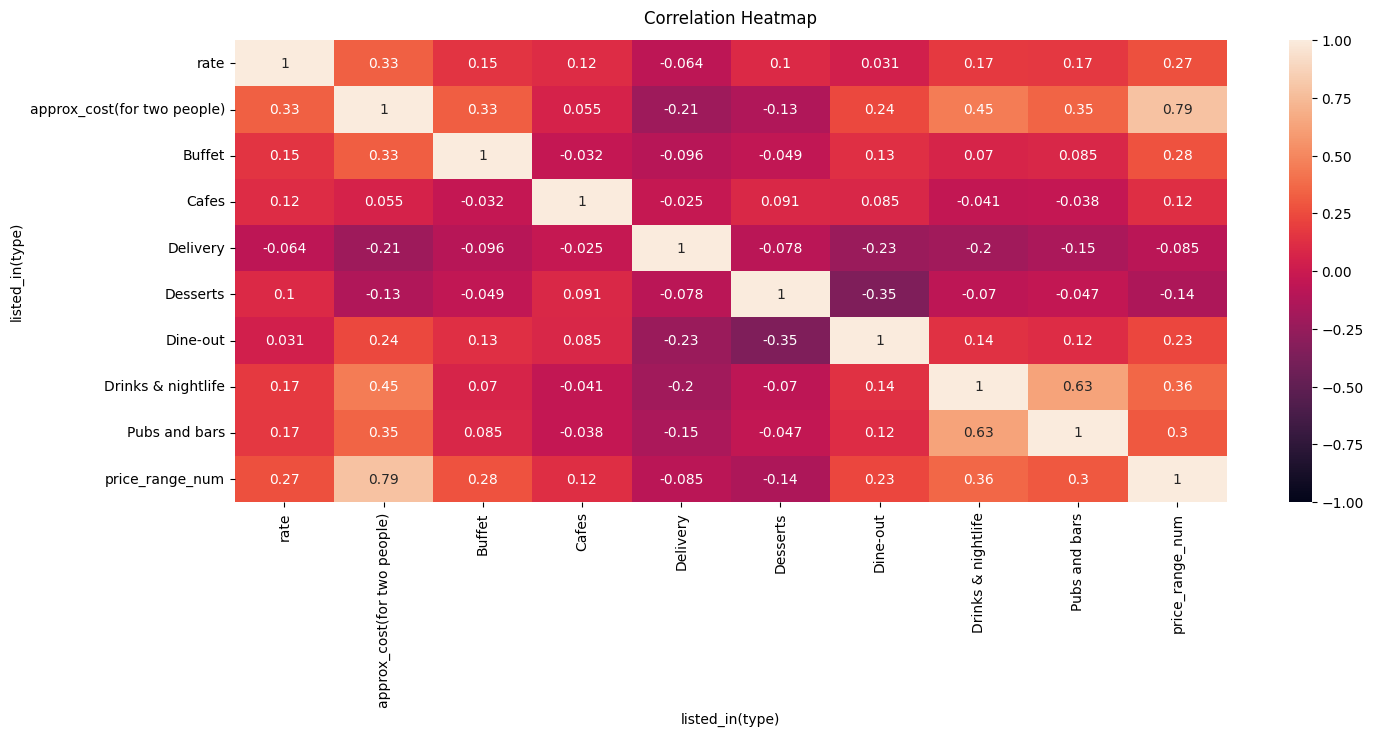

In [61]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(res_type_df2.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Most insights offered by the correlation matrix have been found and discussed earlier. The one worth mentioning is the how high the correlation is between Drinks & Nightlife v/s Rating when compared to Buffets v/s Rating. This goes to show how our suggestion holds.

C:\Users\aryan\AppData\Local\Temp\ipykernel_7616\70299814.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(rest_data.corr(), vmin=-1, vmax=1, annot=True)


Text(0.5, 1.0, 'Correlation Heatmap')

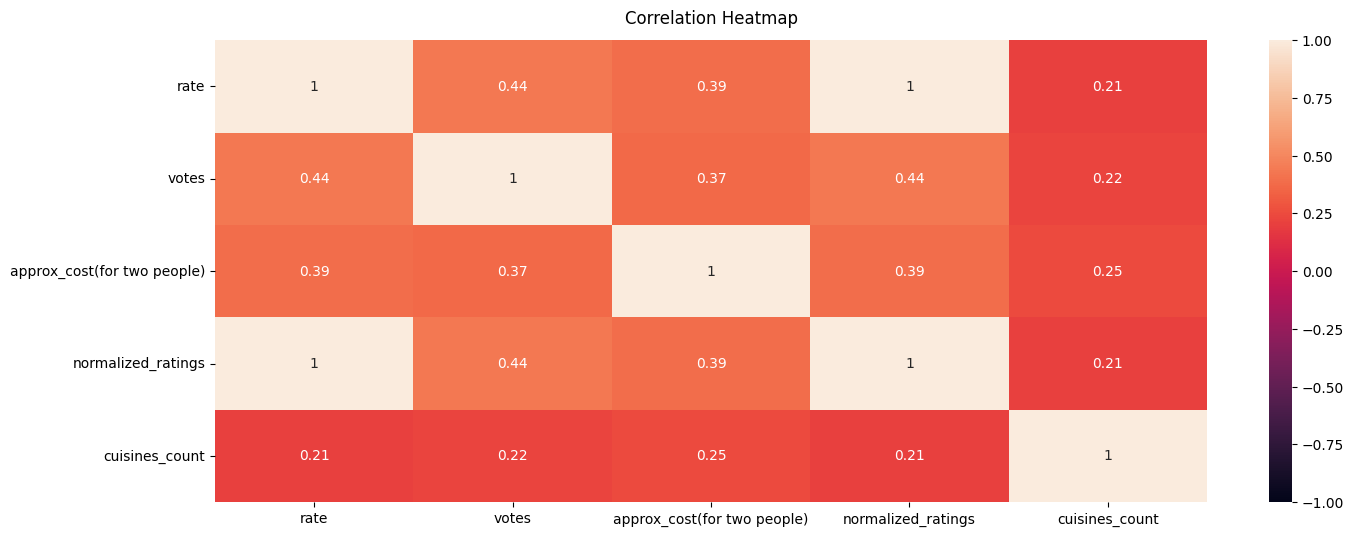

In [62]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(rest_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

From this correlation matrix, we can get 2 insights:
- There is a high correlation between ratings and votes.  Although the number of votes is a factor not in our control as that depends on the success of the restaurant as long as how long the the restaurant has been running. However, this tells us that when starting the restaurant we should incentivize voting at our restaurant. This could be in the form of schemes like "If you rate us on Zomato, we will give you a free dessert".
- The number of cuisines offered is positively correlated with the rating. To be very honest, I would have expected the opposite as offering lesser cuisines would make it seem like a restaurant that specialises whereas offering more cuisines would make it seem like the restaurant is trying to please everyone (which is generally not seem as a better trait when compared with a specialist - "Jack of all trades, master of none"). Unfortunately for us, since this observation/inference was made after looking at the data performing a hypothesis test on this would be against the rules of testing. So, we will just report a p-value that can be looked at but not used as the basis of making a desicion.

In [63]:
#We do a one-tailed ttest to see if the pearsson correlation coefficient is statistically significant
from scipy.stats import pearsonr, ttest_rel, t

rest_data1 = rest_data.copy()
rest_data1.dropna(subset='rate',inplace=True)
corr, pval = pearsonr(rest_data1['cuisines_count'], rest_data1['rate'])
t_stat, pval_t = ttest_rel(rest_data1['cuisines_count'], rest_data1['rate'])

print('Pearson correlation coefficient:', corr)
print('One-tailed t-test p-value:', pval_t/2) #One-Tailed t-test

Pearson correlation coefficient: 0.20674347150298703
One-tailed t-test p-value: 0.0


We see that the p-value is statistically significant. Does that tell us, that the more cuisines you offer, the better your rating? <b>NO</b>.
<br>
<br>
We have to keep in mind that we made this inference after looking at the complete data so we cannot arrive at that conclusion. Additionally, we see that the degree of freedoms here will be very high (n-2), so even a very slight change in correlation values would appear significantly significant.
<br>
As mentioned earlier, this p-value and hypothesis value is just reported for completion purposes, but not as something actionable.

We try to look at why cuisine count has positive correlation through a deep dive

In [64]:
rest_data['cuisines_count'].median()

2.0

In [65]:
n = len(Buffet_df['cuisines'])
a = Buffet_df['cuisines']
a = a.reset_index()
a.drop('index',axis=1,inplace=True)
buffet_cuisine_count = np.zeros(n)
for i in range(n):
    buffet_cuisine_count[i] = len(a.iloc[i][0].split(','))
np.median(buffet_cuisine_count)

3.0

In [66]:
n = len(DrinksAndNightlife_df['cuisines'])
a = DrinksAndNightlife_df['cuisines']
a = a.reset_index()
a.drop('index',axis=1,inplace=True)
nightlife_cuisine_count = np.zeros(n)
for i in range(n):
    nightlife_cuisine_count[i] = len(a.iloc[i][0].split(','))
np.median(nightlife_cuisine_count)

3.0

We see that the median cuisines offered through all restaurants is 2. However, the median cuisines offered by Buffets and Drinks and Nightlife is 3. Since these are the best rated categories they effectively contribute to telling a story that cuisine counts and rates are positively correlated.

# Implementing bootstrap and confidence intervals

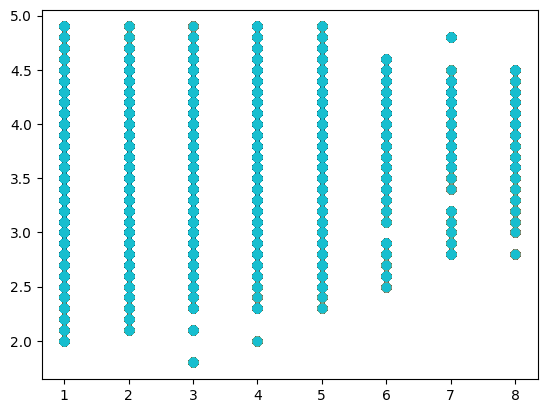

(array([  3.,  25.,  47.,  99., 172., 250., 246.,  96.,  54.,   8.]),
 array([0.20674347, 0.20674347, 0.20674347, 0.20674347, 0.20674347,
        0.20674347, 0.20674347, 0.20674347, 0.20674347, 0.20674347,
        0.20674347]),
 <BarContainer object of 10 artists>)

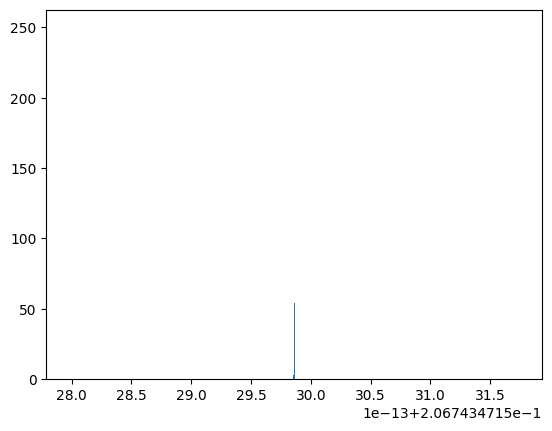

In [67]:
#Bootstrap and Fisher Transformation Method for Confidence Intervals
n = len(rest_data1)
cuisine_count = list(rest_data1['cuisines_count'].values)
rates = list(rest_data1['rate'].values)

corr_coeff_list, fisher_tran = [], []
batch = 1000
indices = list(np.arange(len(rest_data1)))
for i in range(batch): 
    indxs = random.sample(indices, n)
    cuis_sample = [cuisine_count[j] for j in indxs]
    rate_sample = [rates[j] for j in indxs]
    plt.scatter(cuis_sample, rate_sample, label ='Sample{}'.format(i))
    corr_coeff = np.corrcoef(cuis_sample, rate_sample)[0,1]
    corr_coeff_list.append(corr_coeff)
    fisher_tran.append((1/2) * np.log((1 + corr_coeff)/ (1 - corr_coeff)))

plt.show()   
plt.hist(corr_coeff_list)


In [68]:
#Calculate values for confidence intervals
from statistics import NormalDist

alpha = 0.05
c_alpha = NormalDist().inv_cdf(1-alpha/2)

#Calculate original correlation coefficient
corr_coeff_og = rest_data1['cuisines_count'].corr(rest_data1['rate'])

#Calculate c_alpha * sigma_fisher
mod_CI = c_alpha * np.sqrt(np.array(fisher_tran).var())

#Invert fisher transformation on c*sigma 
inv_CI = ((np.exp(2 * mod_CI)) - 1) / ((np.exp(2 * mod_CI)) + 1)
inv_left = corr_coeff_og - inv_CI
inv_right = corr_coeff_og + inv_CI

#Final confidence interval: 
conf_int = np.column_stack((inv_left, inv_right))
conf_int
print('Confidence interval is:', conf_int)

#Show with separated notation: 
print('Confidence interval (detailed) is: [{0:.4f} - {1:.2E}, {0:.4f} + {1:.2E}]'.format(corr_coeff_og, inv_CI))


Confidence interval is: [[0.20674347 0.20674347]]
Confidence interval (detailed) is: [0.2067 - 3.33E-16, 0.2067 + 3.33E-16]


### How do we know if our ideal configurations are indeed ideal?

Through our analysis in the previous section, we came up with some configurations for restaurants. Now we try to see wether or not they would work. Since our success metric remains to be ratings, we would like to take on an ML approach to evaluate our restaurants. 
<br>
We will build a model where all our restaurants will go in as test data, and the outcome rating will be noted as the ground truth of this restaurant.
<br>
To build this ML model, we will use some regression techniques. We will use training and testing data from our current data to choose the right ML model and do the required hyperparameter tuning.
<br>
<br>
TLDR: Build a "rating predictor" regression ML model. Feed in our ideal restaurants as test input data to see the rating they would have gotten had they existed.

Before proceeding onto that part, we will set a baseline accuracy of what our model should outperform. Since we know that there is strong correlation between approx_cost and ratings, we will build a simple linear regression model using that as the only variable. The accuracy of this model would be our baseline accuracy going forward.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = res_type_df1['approx_cost(for two people)'].values.reshape(-1, 1)  
y = res_type_df1['rate'].values.reshape(-1, 1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute error:', mae)

Mean Absolute error: 0.3296634470658762


We use the mean absolute error as it is more interpretable. This shows us that jut using the approx cost, helps us make a decent model but it is nowehere as ideal. This also highlights the question as to really how important is approx_cost and if just setting up a posh restaurant will guarantee you success.

### Is Approx Cost that important?

As we had highlighted before, it is certainly an important parameter but not all that is important. We saw that 50% of $$$$ restaurants don't outperform the 90 percentile mark. Infact, 25% of those restaurants lie below the median rating in Bangalore. This tells us that there are certainly other factors that make the ideal restaurant. So this brings the question, what are these factors (other than those we already described)?
<br>
To answer this question, we will look at the reviews in the next phase to identify things that matter the most to a consumer in Bangalore (especially in the realms of our ideal restaurant). This could highlight things like service and taste to show us what we should invest in the most.

## NLP Time (What really matters)

### Segregating the 5 star and 1 star reviews

In [87]:
reviews_df = rest_data.drop_duplicates(subset=['reviews_list'])
reviews_df = reviews_df[reviews_df['reviews_list'].apply(lambda x: len(x) >= 5)]

In [88]:
import re
def extract_reviews(rating, reviews):
    pattern = r"\(\'Rated {}\', \'(.*?)\'\)".format(rating)
    matches = re.findall(pattern, reviews)
    return matches

In [89]:
reviews_1 = {}
reviews_5 = {}
for i in range(len(reviews_df)-1):
    reviews_1[i] = extract_reviews("1.0", reviews_df['reviews_list'].iloc[i])
    reviews_5[i] = extract_reviews("5.0", reviews_df['reviews_list'].iloc[i])

In [90]:
reviews_df.drop(index=reviews_df.index[-1],axis=0,inplace=True)

In [91]:
reviews_1_list = [reviews_1[i] for i in range(len(reviews_1))]
reviews_5_list = [reviews_5[i] for i in range(len(reviews_5))]

reviews_df.insert(loc=len(reviews_df.columns), column='reviews_1', value=reviews_1_list)
reviews_df.insert(loc=len(reviews_df.columns), column='reviews_5', value=reviews_5_list)


In [92]:
reviews_df['reviews_1'] = [[review.replace('RATED', '') for review in review_list] for review_list in reviews_df['reviews_1']]
reviews_df['reviews_1'] = [[review.replace('\\n', ' ') for review in review_list] for review_list in reviews_df['reviews_1']]
reviews_df['reviews_5'] = [[review.replace('RATED', '') for review in review_list] for review_list in reviews_df['reviews_5']]
reviews_df['reviews_5'] = [[review.replace('\\n', ' ') for review in review_list] for review_list in reviews_df['reviews_5']]

In [93]:
reviews_df['reviews_5'][0]

['   The best thing about the place is itÃ\x83\\x83Ã\x82\\x83Ã\x83\\x82Ã\x82\\x82Ã\x83\\x83Ã\x82\\x82Ã\x83\\x82Ã\x82\\x92s ambiance. Second best thing was yummy ? food. We try buffet and buffet food was not disappointed us. Test ?. ?? ?? ?? ?? ?? Quality ?. ??????????. Service: Staff was very professional and friendly.  Overall experience was excellent.  subirmajumder85.wixsite.com',
 '   Great food and pleasant ambience. Expensive but Coll place to chill and relax......  Service is really very very good and friendly staff...  Food : 5/5 Service : 5/5 Ambience :5/5 Overall :5/5',
 '   Overdelighted by the service and food provided at this place. A royal and ethnic atmosphere builds a strong essence of being in India and also the quality and taste of food is truly authentic. I would totally recommend to visit this place once.']

In [94]:
def clean_text(text):
    text = text.encode('ascii', 'ignore').decode()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [95]:
reviews_df['reviews_1'] = reviews_df['reviews_1'].apply(lambda x: [clean_text(review) for review in x])
reviews_df['reviews_5'] = reviews_df['reviews_5'].apply(lambda x: [clean_text(review) for review in x])

In [96]:
reviews_df['reviews_5'][0]

['the best thing about the place is itxxxxxxxxs ambiance second best thing was yummy food we try buffet and buffet food was not disappointed us test quality service staff was very professional and friendly overall experience was excellent subirmajumderwixsitecom',
 'great food and pleasant ambience expensive but coll place to chill and relax service is really very very good and friendly staff food service ambience overall',
 'overdelighted by the service and food provided at this place a royal and ethnic atmosphere builds a strong essence of being in india and also the quality and taste of food is truly authentic i would totally recommend to visit this place once']

### Making a wordcloud to see which terms we would want to search for

In [32]:
all_reviews_1 = ' '.join([review for review_list in reviews_df['reviews_1'] for review in review_list])
all_reviews_5 = ' '.join([review for review_list in reviews_df['reviews_5'] for review in review_list])

In [33]:
def preprocess(text):
    words = text.split()
    words = [word for word in words if len(word) >= 3]
    return ' '.join(words)

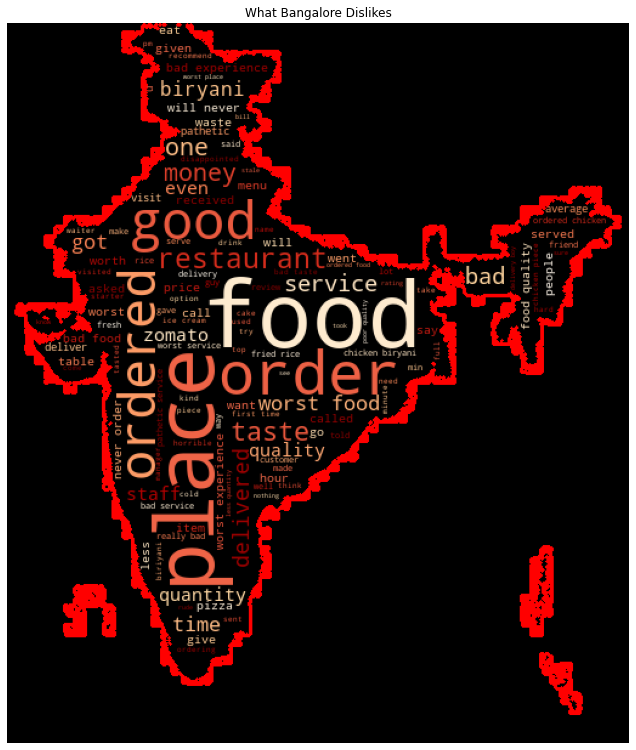

In [61]:
from wordcloud import WordCloud
from PIL import Image

mask = np.array(Image.open('/Users/mallorysico/Desktop/ProbabilityAndStatistics_1002/Project/India_mask.jpg'))
wordcloud_1 = WordCloud(background_color='black', min_font_size=5, mask = mask, width = 800, height = 800, colormap='OrRd', contour_color='red', contour_width=2.5).generate(all_reviews_1)
wordcloud_5 = WordCloud(background_color='white', min_font_size=5, mask = mask, width = mask.shape[1], height = mask.shape[0], colormap='ocean_r', contour_color='green', contour_width=2.5).generate(all_reviews_5)

plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('What Bangalore Dislikes')
  
plt.show()

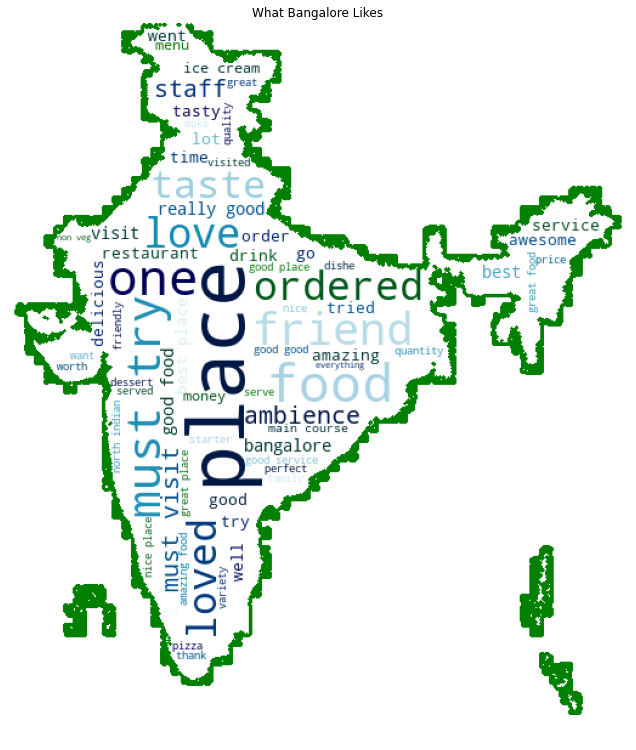

In [62]:
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_5)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('What Bangalore Likes')

plt.show()

Words to search for GOOD:
<br>
Service: staff, service, friendly, good service
<br>
Vibe: vibe, ambience, ambiance
<br>
Group: friend, friends
<br>
Tasty: tasty, taste, great food, good food, delicious
<br>
Money: money, worth

In [103]:

def extract_word_counts(lst):
    if len(lst) == 0:
        return 0, 0, 0, 0, 0, 0
    else:
        review_count = len(lst)
        service_count = sum([1 for review in lst if ('staff' in review or 'service' in review or 'friendly' in review or 'good service' in review)]) / len(lst)
        vibe_count = sum([1 for review in lst if ('ambience' in review or 'ambiance' in review or 'vibe' in review)]) / len(lst)
        group_count = sum([1 for review in lst if ('friend' in review or 'friends' in review)]) / len(lst)
        taste_count = sum([1 for review in lst if ('tasty' in review or 'taste' in review or 'great food' in review or 'good food' in review or 'delicious' in review)]) / len(lst)
        value_count = sum([1 for review in lst if ('money' in review or 'worth' in review)]) / len(lst)
        return review_count, service_count, vibe_count, group_count, taste_count, value_count

# apply the function to create the new columns
reviews_df[['Reviews_5_Count','Service_5', 'Vibe_5', 'Group_5', 'Taste_5', 'Value_5']] = reviews_df['reviews_5'].apply(lambda x: pd.Series(extract_word_counts(x)))


In [109]:
print('Correlation between Ratings and Number of 5* Votes about Service',reviews_df[reviews_df['Reviews_5_Count']>=10]['rate'].corr(reviews_df[reviews_df['Reviews_5_Count']>=10]['Service_5']))
print('Correlation between Ratings and Number of 5* Votes about Vibe',reviews_df[reviews_df['Reviews_5_Count']>=10]['rate'].corr(reviews_df[reviews_df['Reviews_5_Count']>=10]['Vibe_5']))
print('Correlation between Ratings and Number of 5* Votes about Groups',reviews_df[reviews_df['Reviews_5_Count']>=10]['rate'].corr(reviews_df[reviews_df['Reviews_5_Count']>=10]['Group_5']))
print('Correlation between Ratings and Number of 5* Votes about Taste',reviews_df[reviews_df['Reviews_5_Count']>=10]['rate'].corr(reviews_df[reviews_df['Reviews_5_Count']>=10]['Taste_5']))
print('Correlation between Ratings and Number of 5* Votes about Value',reviews_df[reviews_df['Reviews_5_Count']>=10]['rate'].corr(reviews_df[reviews_df['Reviews_5_Count']>=10]['Value_5']))

Correlation between Ratings and Number of 5* Votes about Service 0.4039398725569693
Correlation between Ratings and Number of 5* Votes about Vibe 0.509505318900302
Correlation between Ratings and Number of 5* Votes about Groups 0.23487115326067398
Correlation between Ratings and Number of 5* Votes about Taste 0.06951838020947011
Correlation between Ratings and Number of 5* Votes about Value 0.15074154877962878
